In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt 
from matplotlib.patches import Rectangle
from IPython.display import Image, display
import pandas as pd

#### Functions

In [2]:
def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul+1):
        for j in range(39):
            if (fmask[j, i]== 0):
                try:
                    rect = Rectangle((u_lons[i-1]/m2lon, w_depths[j]), u_lons[i]/m2lon-u_lons[i-1]/m2lon, w_depths[j+1]-w_depths[j])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

#TODO: Rename this function (in all files)
def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel,NW=False):
    
    if NW == True:
        latgridf = latgridi-1 #actually lon
        fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
        tmask = mesh.tmask[0]
        
        lons = data.init_lat[(data.final_section != 0)]
        
        f_lons = mesh.glamf[0,:, latgridf]
        u_lons = mesh.glamv[0,:, latgridf]
        w_depths = mesh.gdepw_1d
    else:
        latgridf = latgridi-1
        fmask = mesh.vmask[0, :, latgridf]
        tmask = mesh.tmask[0]
            
        lons = data.init_lon[(data.final_section != 0)]
            
        f_lons = mesh.glamf[0, latgridf]
        u_lons = mesh.glamv[0, latgridf]
        w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.dense
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec-1)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE+1:1]/m2lon),w_depths[0,0:depi+1]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    try:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    except:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    if NW==True:
        axv.set_xlabel('Latitude (°W)')
    else:
        axv.set_xlabel('Longitude (°N)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(f_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

### Import data

In [3]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [4]:
file1 = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtoadm_haro_finalsalt.csv')
file2 = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtoadm_haro_finaltransp.csv')


pathway = ['vstoharo','vstoros','vstosjc','vstoadm','prtoharo','prtoros','prtosjc','prtogulf','harotovs','rostovs','sjctovs','admtovs','gulftoros','harotoros','sjctoros','prtoros_RS',
           'rostoadm','rostovs_RS','rostoharo','rostosjc','rostodec']
variables = ['final_salt','final_transp','final_temp','init_salt','init_transp','init_temp','final_lat','final_lon','init_lat','init_lon','init_z','final_z']
dict_all = {}
for pathw in pathway:
    dict_all[pathw] = {}
    for variable in variables:
        fpath = f'/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/{pathw}_{variable}.csv'
        dict_all[pathw][variable] = pd.read_csv(fpath)


In [5]:
dict_all.keys()

dict_keys(['vstoharo', 'vstoros', 'vstosjc', 'vstoadm', 'prtoharo', 'prtoros', 'prtosjc', 'prtogulf', 'harotovs', 'rostovs', 'sjctovs', 'admtovs', 'gulftoros', 'harotoros', 'sjctoros', 'prtoros_RS', 'rostoadm', 'rostovs_RS', 'rostoharo', 'rostosjc', 'rostodec'])

In [6]:
lonWharo = 215
lonEharo = 244
latharo = 300
lonWros=281
lonEros=305
latros = 267
latsjc = 281
lonWsjc = 261
lonEsjc = 267
lonWadm = 230
lonEadm = 262
latadm = 218
lonWg1 = 234
lonEg1 = 253
latg1 = 386
lonWpr = 260
lonEpr = 310
latpr = 386

months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

days_month = [31,28,31,30,31,30,31,31,30,31,30,31]

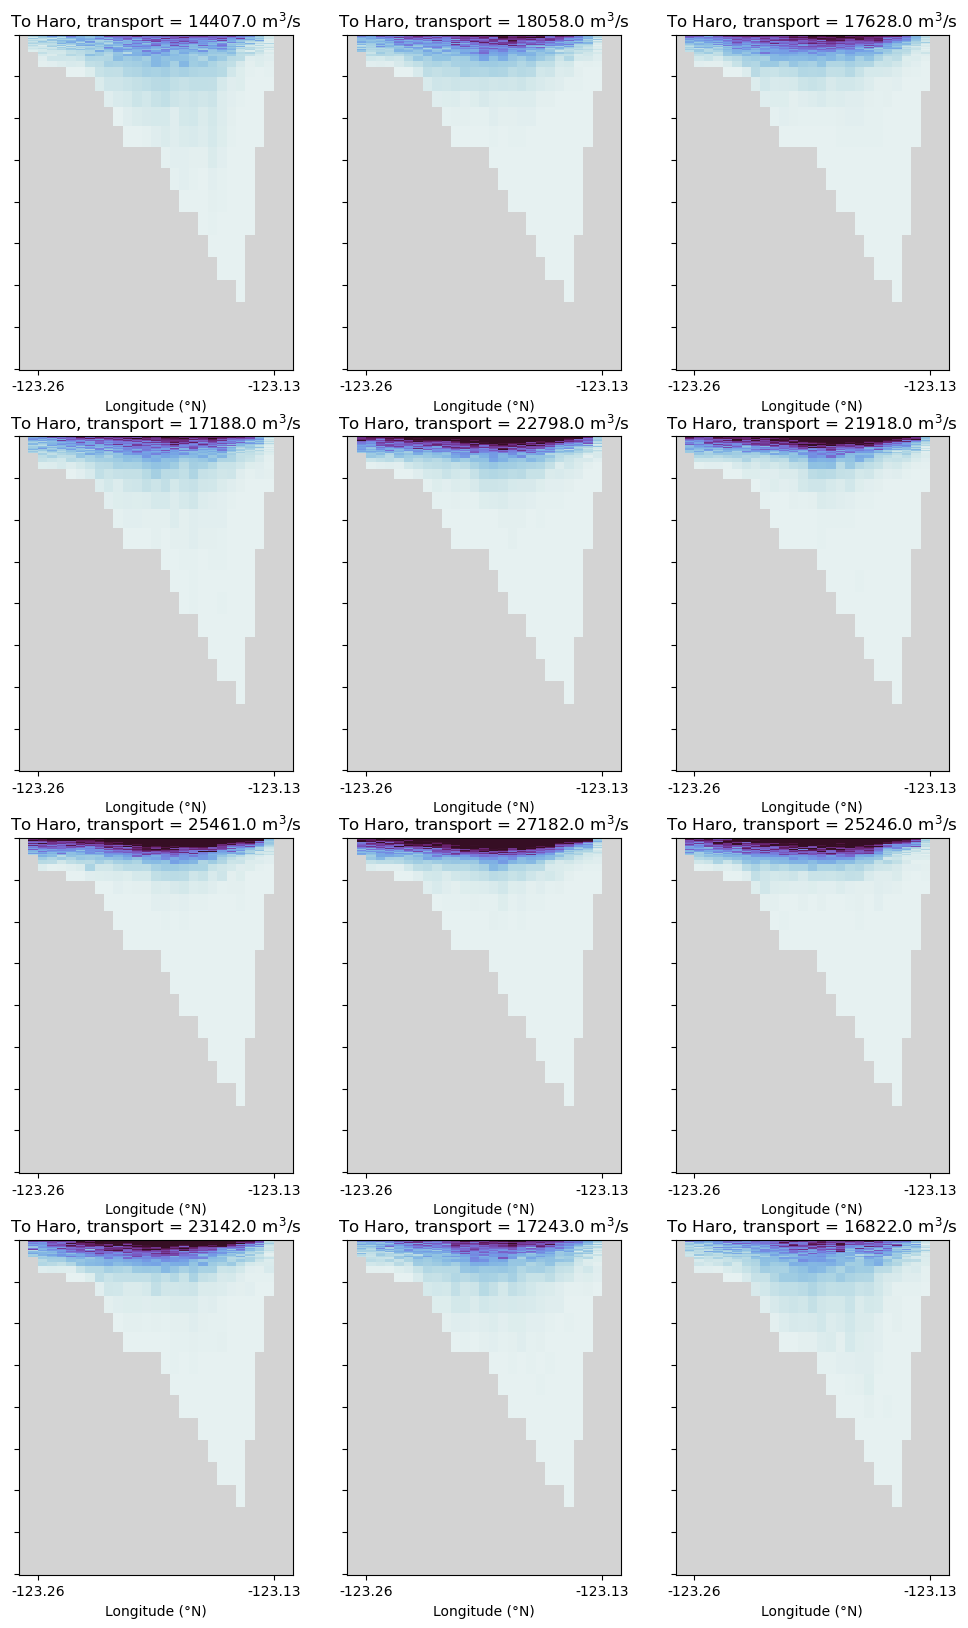

In [7]:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9],[ax10,ax11,ax12]] = plt.subplots(4,3,figsize=(12,20))

for ii,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]):
    title = 'To Haro, transport = ' + str(np.round(np.sum(dict_all['prtoharo']['final_transp'][months[ii]])/(23*days_month[ii]))) + f' m$^3$/s'
    plotCS(ax,dict_all['prtoharo']['final_lon'][months[ii]].dropna(),dict_all['prtoharo']['final_z'][months[ii]].dropna(),dict_all['prtoharo']['final_transp'][months[ii]].dropna(),lonWharo,lonEharo,latharo,38,0.1,23*30,title,False,False)

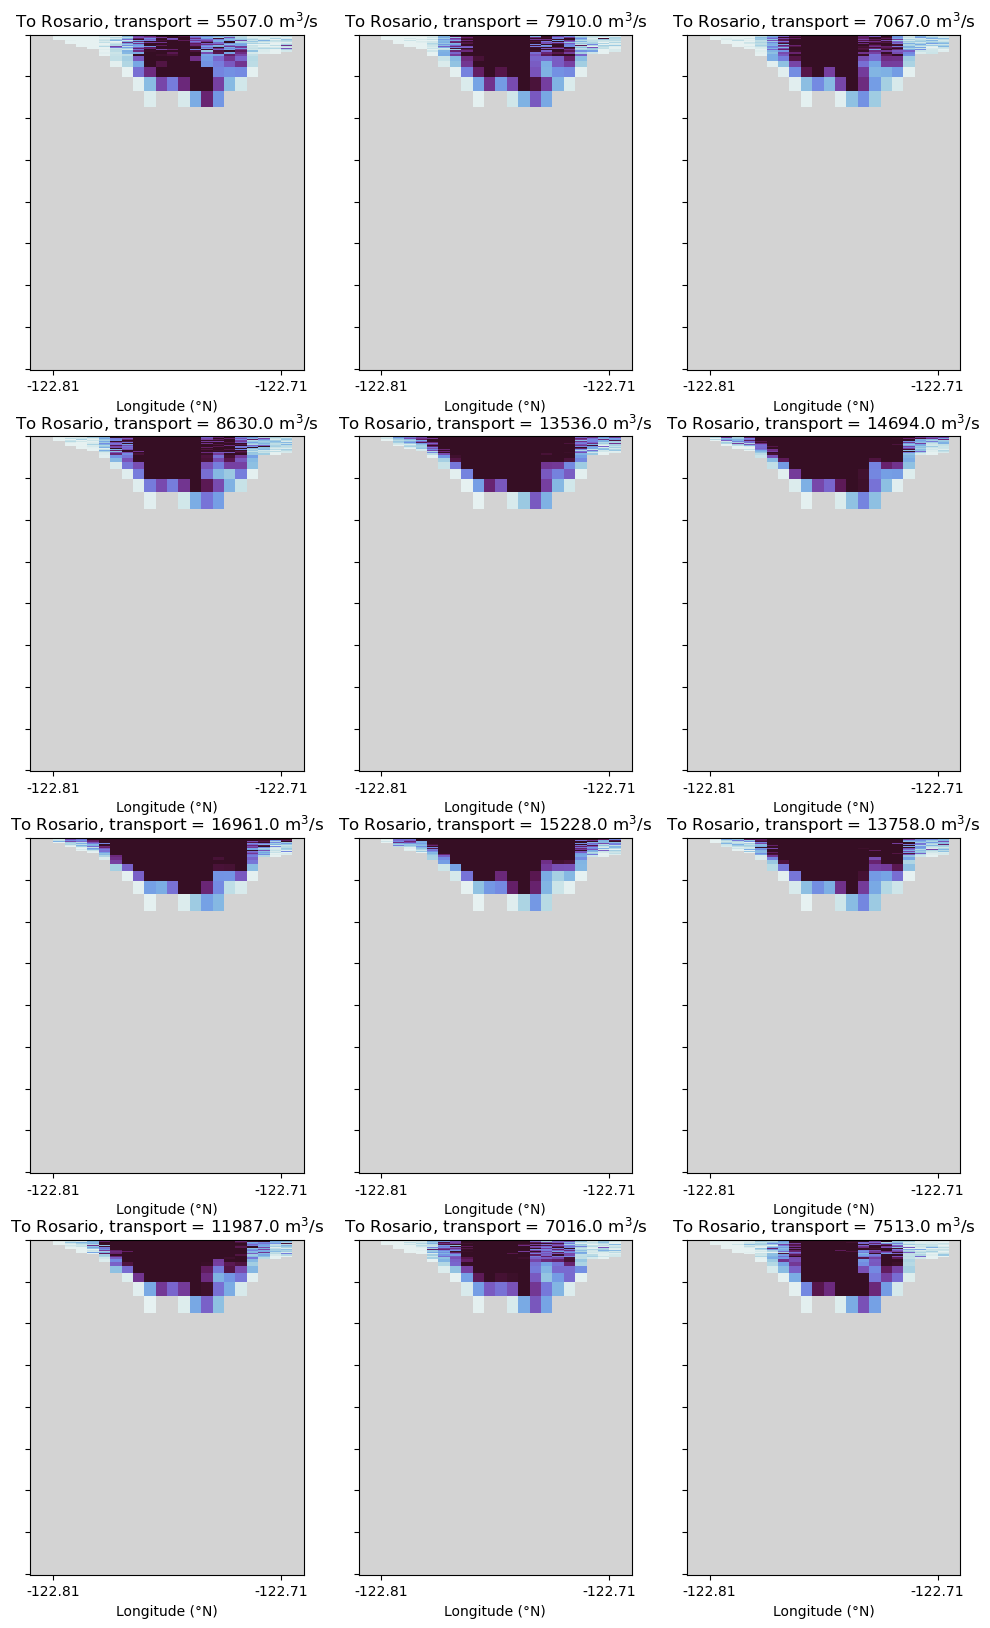

In [8]:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9],[ax10,ax11,ax12]] = plt.subplots(4,3,figsize=(12,20))

for ii,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]):
    title = 'To Rosario, transport = ' + str(np.round(np.sum(dict_all['prtoros']['final_transp'][months[ii]])/(23*days_month[ii]))) + f' m$^3$/s'
    plotCS(ax,dict_all['prtoros']['final_lon'][months[ii]].dropna(),dict_all['prtoros']['final_z'][months[ii]].dropna(),dict_all['prtoros']['final_transp'][months[ii]].dropna(),lonWros,lonEros,latros,38,0.02,23*30,title,False,False)

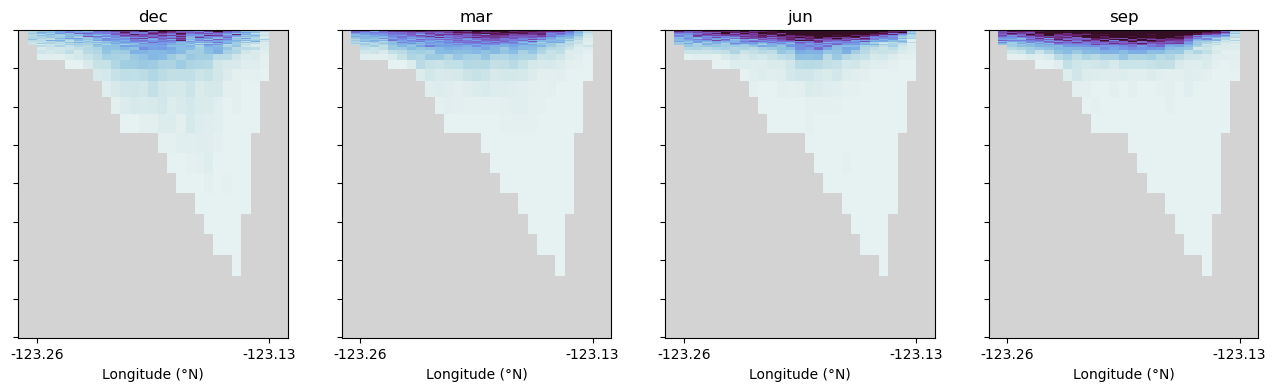

In [9]:
fig,[ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=(16,4))

for ii,ax in enumerate([ax1,ax2,ax3,ax4]):
    plotCS(ax,dict_all['prtoharo']['final_lon'][months[ii*3-1]].dropna(),dict_all['prtoharo']['final_z'][months[ii*3-1]].dropna(),dict_all['prtoharo']['final_transp'][months[ii*3-1]].dropna(),lonWharo,lonEharo,latharo,38,0.1,23*days_month[ii*3-1],months[ii*3-1],False,False)

Text(0.5, 0.98, 'Forward PR seeding')

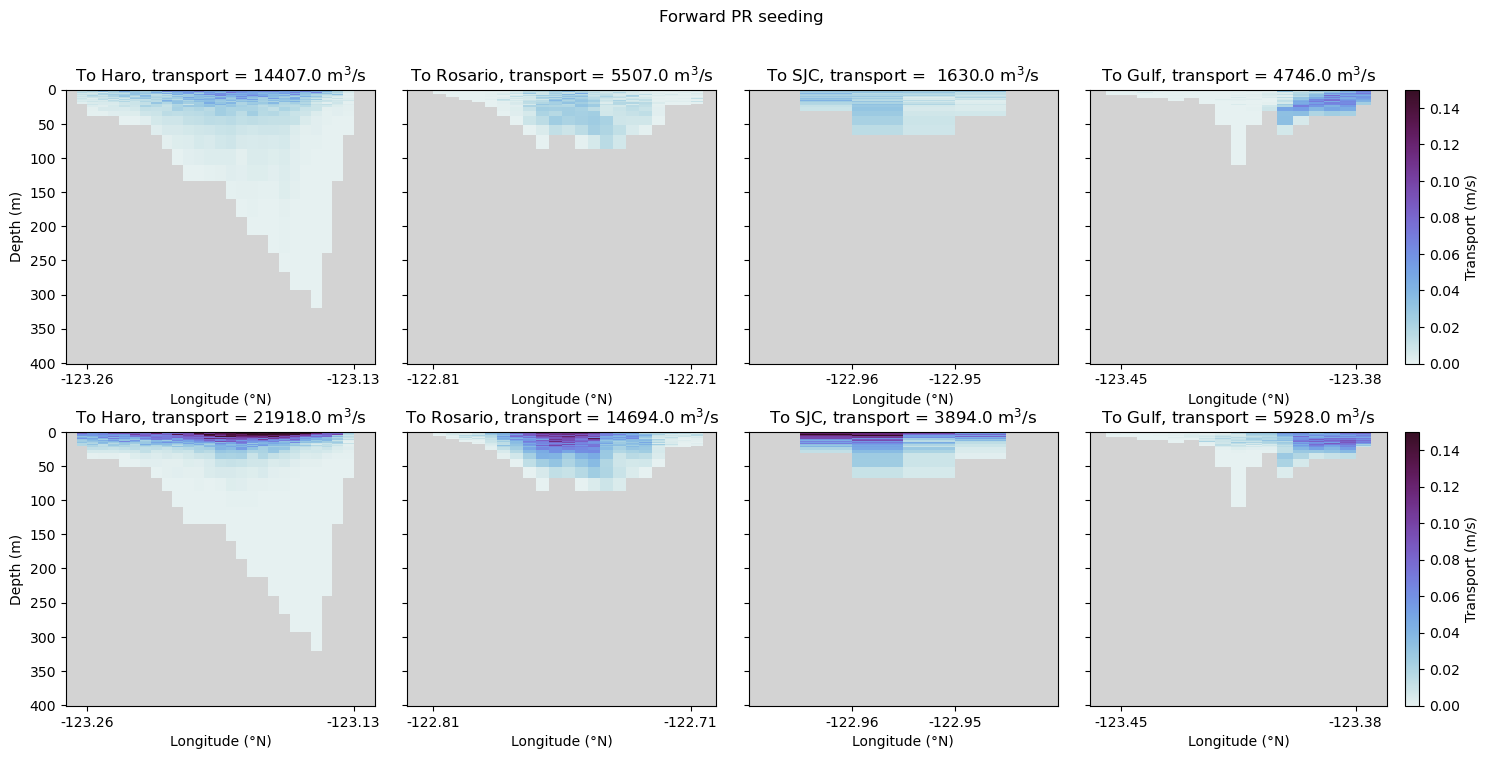

In [10]:
idx_dec = 0
idx_jun = 5

title = 'To Haro, transport = ' + str(np.round(np.sum(dict_all['prtoharo']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title2 = 'To Rosario, transport = ' + str(np.round(np.sum(dict_all['prtoros']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title3 = 'To SJC, transport =  ' + str(np.round(np.sum(dict_all['prtosjc']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title4 = 'To Gulf, transport = ' + str(np.round(np.sum(dict_all['prtogulf']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'

title5 = 'To Haro, transport = ' + str(np.round(np.sum(dict_all['prtoharo']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title6 = 'To Rosario, transport = ' + str(np.round(np.sum(dict_all['prtoros']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title7 = 'To SJC, transport = ' + str(np.round(np.sum(dict_all['prtosjc']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title8 = 'To Gulf, transport = ' + str(np.round(np.sum(dict_all['prtogulf']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(18,8),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,dict_all['prtoharo']['final_lon'][months[idx_dec]].dropna(),dict_all['prtoharo']['final_z'][months[idx_dec]].dropna(),dict_all['prtoharo']['final_transp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,0.15,23*days_month[idx_dec],title,False,True)
plotCS(ax2,dict_all['prtoros']['final_lon'][months[idx_dec]].dropna(),dict_all['prtoros']['final_z'][months[idx_dec]].dropna(),dict_all['prtoros']['final_transp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.15,23*days_month[idx_dec],title2,False,False)
plotCS(ax3,dict_all['prtosjc']['final_lon'][months[idx_dec]].dropna(),dict_all['prtosjc']['final_z'][months[idx_dec]].dropna(),dict_all['prtosjc']['final_transp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.15,23*days_month[idx_dec],title3,False,False)
plotCS(ax4,dict_all['prtogulf']['final_lon'][months[idx_dec]].dropna(),dict_all['prtogulf']['final_z'][months[idx_dec]].dropna(),dict_all['prtogulf']['final_transp'][months[idx_dec]].dropna(),lonWg1,lonEg1,latg1,38,0.15,23*days_month[idx_dec],title4,True,False)

plotCS(ax5,dict_all['prtoharo']['final_lon'][months[idx_jun]].dropna(),dict_all['prtoharo']['final_z'][months[idx_jun]].dropna(),dict_all['prtoharo']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.15,23*days_month[idx_jun],title5,False,True)
plotCS(ax6,dict_all['prtoros']['final_lon'][months[idx_jun]].dropna(),dict_all['prtoros']['final_z'][months[idx_jun]].dropna(),dict_all['prtoros']['final_transp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.15,23*days_month[idx_jun],title6,False,False)
plotCS(ax7,dict_all['prtosjc']['final_lon'][months[idx_jun]].dropna(),dict_all['prtosjc']['final_z'][months[idx_jun]].dropna(),dict_all['prtosjc']['final_transp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.15,23*days_month[idx_jun],title7,False,False)
plotCS(ax8,dict_all['prtogulf']['final_lon'][months[idx_jun]].dropna(),dict_all['prtogulf']['final_z'][months[idx_jun]].dropna(),dict_all['prtogulf']['final_transp'][months[idx_jun]].dropna(),lonWg1,lonEg1,latg1,38,0.15,23*days_month[idx_jun],title8,True,False)

fig.subplots_adjust(wspace=0.1,hspace=0.25)
fig.suptitle('Forward PR seeding')

Text(0.5, 0.98, 'Backward VS seeding')

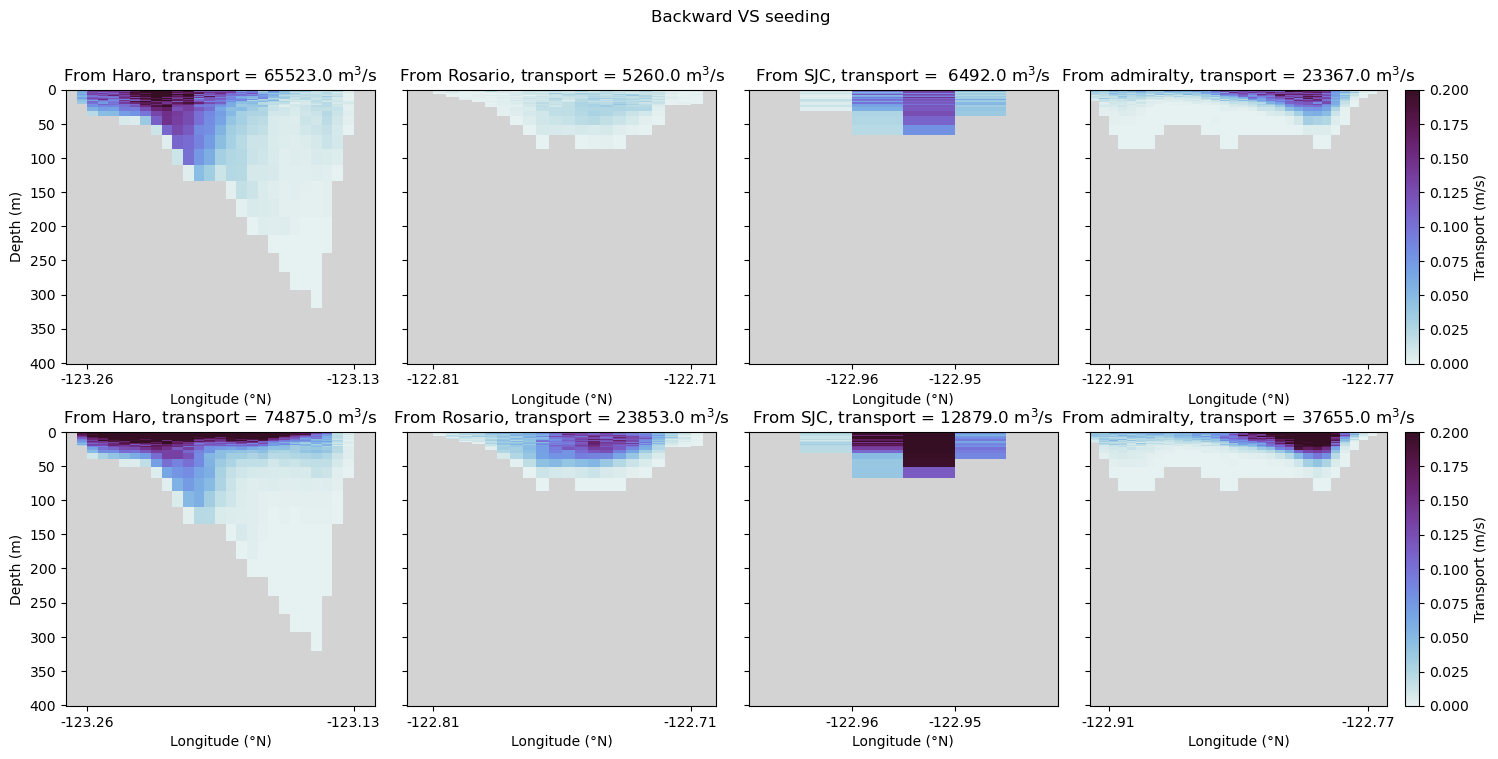

In [11]:
title = 'From Haro, transport = ' + str(np.round(np.sum(dict_all['harotovs']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title2 = 'From Rosario, transport = ' + str(np.round(np.sum(dict_all['rostovs']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title3 = 'From SJC, transport =  ' + str(np.round(np.sum(dict_all['sjctovs']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title4 = 'From admiralty, transport = ' + str(np.round(np.sum(dict_all['admtovs']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'

title5 = 'From Haro, transport = ' + str(np.round(np.sum(dict_all['harotovs']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title6 = 'From Rosario, transport = ' + str(np.round(np.sum(dict_all['rostovs']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title7 = 'From SJC, transport = ' + str(np.round(np.sum(dict_all['sjctovs']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title8 = 'From admiralty, transport = ' + str(np.round(np.sum(dict_all['admtovs']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(18,8),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,dict_all['harotovs']['final_lon'][months[idx_dec]].dropna(),dict_all['harotovs']['final_z'][months[idx_dec]].dropna(),dict_all['harotovs']['final_transp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_dec],title,False,True)
plotCS(ax2,dict_all['rostovs']['final_lon'][months[idx_dec]].dropna(),dict_all['rostovs']['final_z'][months[idx_dec]].dropna(),dict_all['rostovs']['final_transp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_dec],title2,False,False)
plotCS(ax3,dict_all['sjctovs']['final_lon'][months[idx_dec]].dropna(),dict_all['sjctovs']['final_z'][months[idx_dec]].dropna(),dict_all['sjctovs']['final_transp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_dec],title3,False,False)
plotCS(ax4,dict_all['admtovs']['final_lon'][months[idx_dec]].dropna(),dict_all['admtovs']['final_z'][months[idx_dec]].dropna(),dict_all['admtovs']['final_transp'][months[idx_dec]].dropna(),lonWadm,lonEadm,latadm,38,0.2,23*days_month[idx_dec],title4,True,False)

plotCS(ax5,dict_all['harotovs']['final_lon'][months[idx_jun]].dropna(),dict_all['harotovs']['final_z'][months[idx_jun]].dropna(),dict_all['harotovs']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_jun],title5,False,True)
plotCS(ax6,dict_all['rostovs']['final_lon'][months[idx_jun]].dropna(),dict_all['rostovs']['final_z'][months[idx_jun]].dropna(),dict_all['rostovs']['final_transp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_jun],title6,False,False)
plotCS(ax7,dict_all['sjctovs']['final_lon'][months[idx_jun]].dropna(),dict_all['sjctovs']['final_z'][months[idx_jun]].dropna(),dict_all['sjctovs']['final_transp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_jun],title7,False,False)
plotCS(ax8,dict_all['admtovs']['final_lon'][months[idx_jun]].dropna(),dict_all['admtovs']['final_z'][months[idx_jun]].dropna(),dict_all['admtovs']['final_transp'][months[idx_jun]].dropna(),lonWadm,lonEadm,latadm,38,0.2,23*days_month[idx_jun],title8,True,False)

fig.subplots_adjust(wspace=0.1,hspace=0.25)
fig.suptitle('Backward VS seeding')

Text(0.5, 0.98, 'Forward VS seeding')

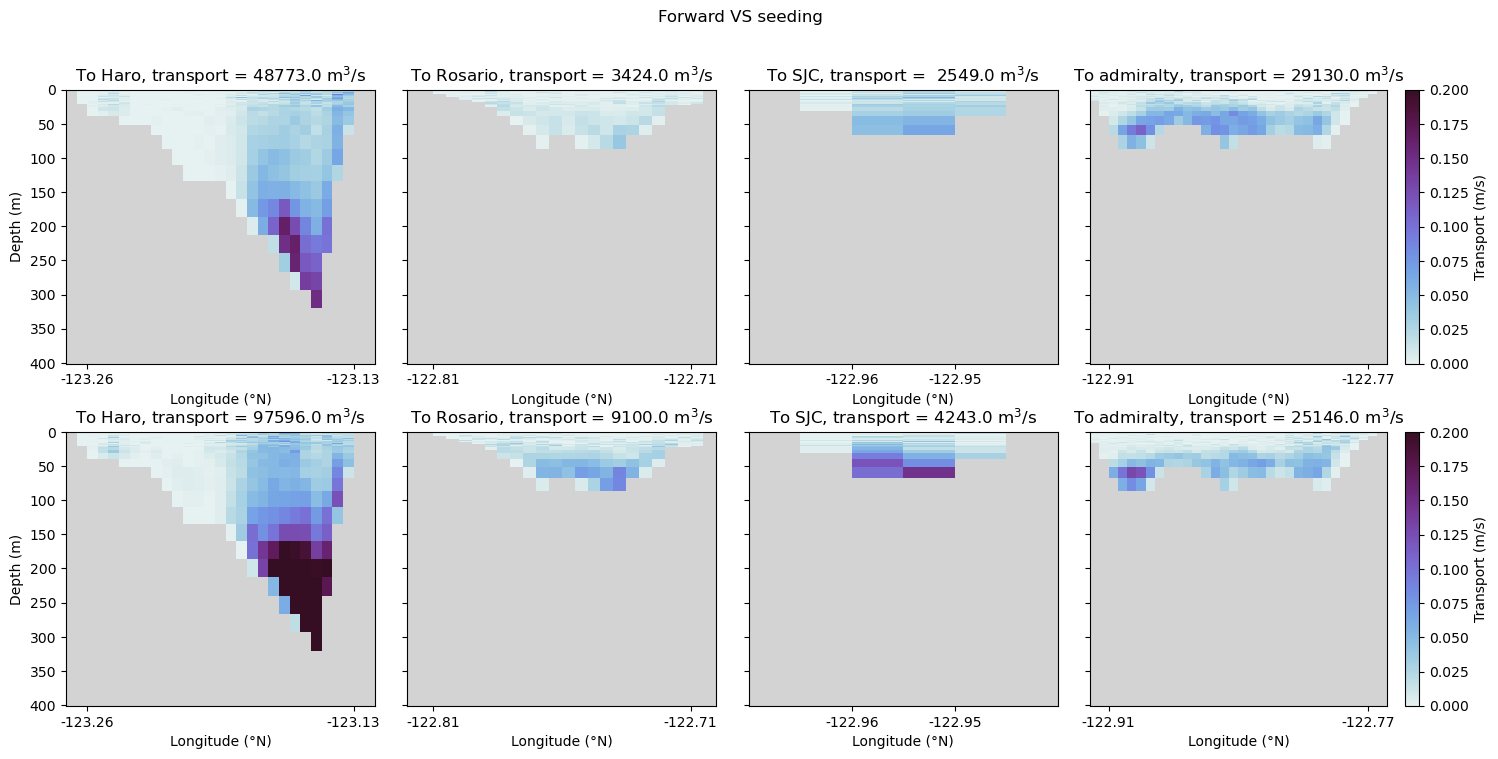

In [18]:
title = 'To Haro, transport = ' + str(np.round(np.sum(dict_all['vstoharo']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title2 = 'To Rosario, transport = ' + str(np.round(np.sum(dict_all['vstoros']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title3 = 'To SJC, transport =  ' + str(np.round(np.sum(dict_all['vstosjc']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title4 = 'To admiralty, transport = ' + str(np.round(np.sum(dict_all['vstoadm']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'

title5 = 'To Haro, transport = ' + str(np.round(np.sum(dict_all['vstoharo']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title6 = 'To Rosario, transport = ' + str(np.round(np.sum(dict_all['vstoros']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title7 = 'To SJC, transport = ' + str(np.round(np.sum(dict_all['vstosjc']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title8 = 'To admiralty, transport = ' + str(np.round(np.sum(dict_all['vstoadm']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(18,8),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,dict_all['vstoharo']['final_lon'][months[idx_dec]].dropna(),dict_all['vstoharo']['final_z'][months[idx_dec]].dropna(),dict_all['vstoharo']['final_transp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,0.15,23*days_month[idx_dec],title,False,True)
plotCS(ax2,dict_all['vstoros']['final_lon'][months[idx_dec]].dropna(),dict_all['vstoros']['final_z'][months[idx_dec]].dropna(),dict_all['vstoros']['final_transp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.15,23*days_month[idx_dec],title2,False,False)
plotCS(ax3,dict_all['vstosjc']['final_lon'][months[idx_dec]].dropna(),dict_all['vstosjc']['final_z'][months[idx_dec]].dropna(),dict_all['vstosjc']['final_transp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.15,23*days_month[idx_dec],title3,False,False)
plotCS(ax4,dict_all['vstoadm']['final_lon'][months[idx_dec]].dropna(),dict_all['vstoadm']['final_z'][months[idx_dec]].dropna(),dict_all['vstoadm']['final_transp'][months[idx_dec]].dropna(),lonWadm,lonEadm,latadm,38,0.2,23*days_month[idx_dec],title4,True,False)

plotCS(ax5,dict_all['vstoharo']['final_lon'][months[idx_jun]].dropna(),dict_all['vstoharo']['final_z'][months[idx_jun]].dropna(),dict_all['vstoharo']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.15,23*days_month[idx_jun],title5,False,True)
plotCS(ax6,dict_all['vstoros']['final_lon'][months[idx_jun]].dropna(),dict_all['vstoros']['final_z'][months[idx_jun]].dropna(),dict_all['vstoros']['final_transp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.15,23*days_month[idx_jun],title6,False,False)
plotCS(ax7,dict_all['vstosjc']['final_lon'][months[idx_jun]].dropna(),dict_all['vstosjc']['final_z'][months[idx_jun]].dropna(),dict_all['vstosjc']['final_transp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.15,23*days_month[idx_jun],title7,False,False)
plotCS(ax8,dict_all['vstoadm']['final_lon'][months[idx_jun]].dropna(),dict_all['vstoadm']['final_z'][months[idx_jun]].dropna(),dict_all['vstoadm']['final_transp'][months[idx_jun]].dropna(),lonWadm,lonEadm,latadm,38,0.2,23*days_month[idx_jun],title8,True,False)

fig.subplots_adjust(wspace=0.1,hspace=0.25)
fig.suptitle('Forward VS seeding')

Text(0.5, 0.98, 'Backwards rosario seeding')

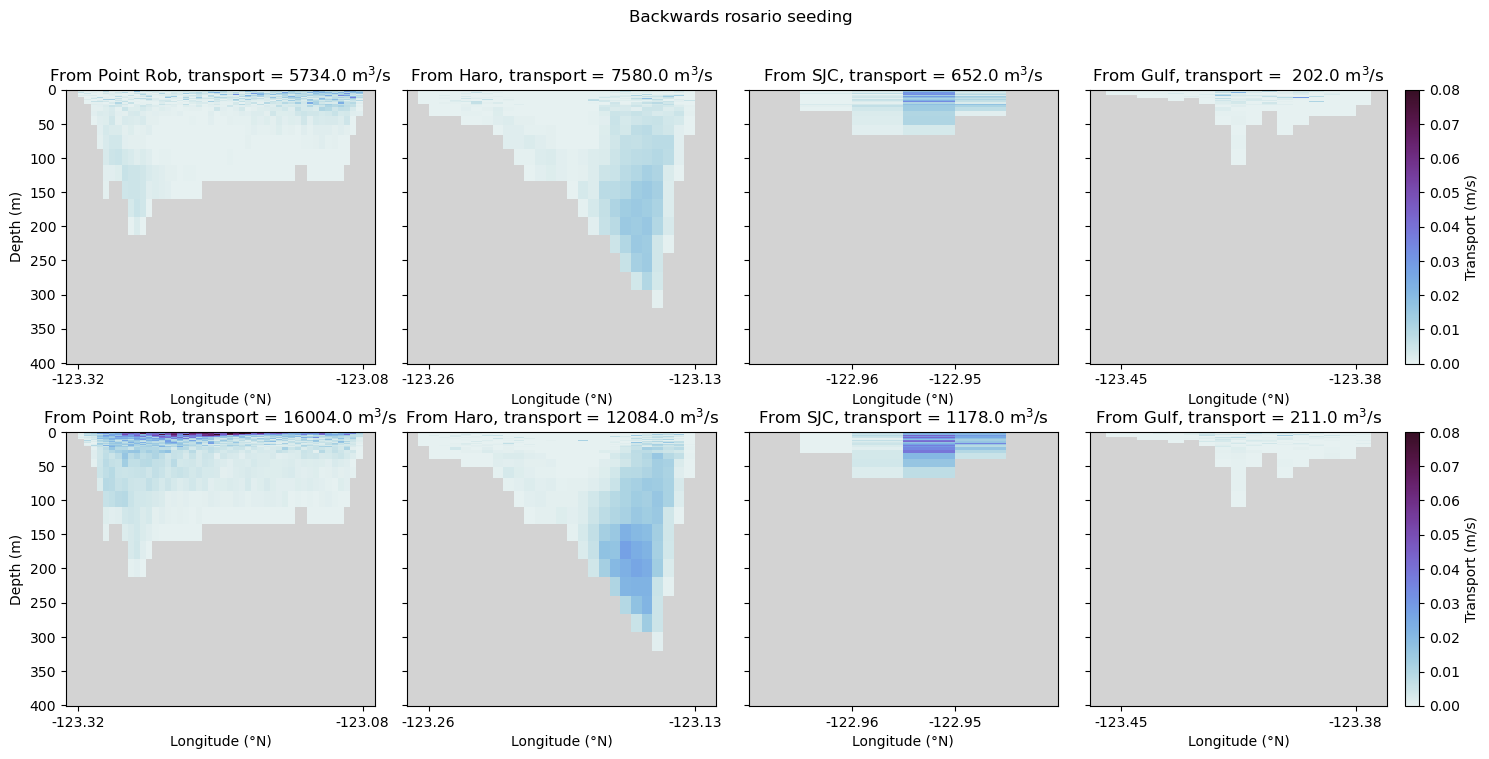

In [24]:
title = 'From Haro, transport = ' + str(np.round(np.sum(dict_all['harotoros']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title2 = 'From Point Rob, transport = ' + str(np.round(np.sum(dict_all['prtoros_RS']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title3 = 'From Gulf, transport =  ' + str(np.round(np.sum(dict_all['gulftoros']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title4 = 'From SJC, transport = ' + str(np.round(np.sum(dict_all['sjctoros']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'

title5 = 'From Haro, transport = ' + str(np.round(np.sum(dict_all['harotoros']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title6 = 'From Point Rob, transport = ' + str(np.round(np.sum(dict_all['prtoros_RS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title7 = 'From Gulf, transport = ' + str(np.round(np.sum(dict_all['gulftoros']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title8 = 'From SJC, transport = ' + str(np.round(np.sum(dict_all['sjctoros']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(18,8),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax2,dict_all['harotoros']['final_lon'][months[idx_dec]].dropna(),dict_all['harotoros']['final_z'][months[idx_dec]].dropna(),dict_all['harotoros']['final_transp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,0.08,23*days_month[idx_dec],title,False,False)
plotCS(ax1,dict_all['prtoros_RS']['final_lon'][months[idx_dec]].dropna(),dict_all['prtoros_RS']['final_z'][months[idx_dec]].dropna(),dict_all['prtoros_RS']['final_transp'][months[idx_dec]].dropna(),lonWpr,lonEpr,latpr,38,0.08,23*days_month[idx_dec],title2,False,True)
plotCS(ax4,dict_all['gulftoros']['final_lon'][months[idx_dec]].dropna(),dict_all['gulftoros']['final_z'][months[idx_dec]].dropna(),dict_all['gulftoros']['final_transp'][months[idx_dec]].dropna(),lonWg1,lonEg1,latg1,38,0.08,23*days_month[idx_dec],title3,True,False)
plotCS(ax3,dict_all['sjctoros']['final_lon'][months[idx_dec]].dropna(),dict_all['sjctoros']['final_z'][months[idx_dec]].dropna(),dict_all['sjctoros']['final_transp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.08,23*days_month[idx_dec],title4,False,False)

plotCS(ax6,dict_all['harotoros']['final_lon'][months[idx_jun]].dropna(),dict_all['harotoros']['final_z'][months[idx_jun]].dropna(),dict_all['harotoros']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.08,23*days_month[idx_jun],title5,False,False)
plotCS(ax5,dict_all['prtoros_RS']['final_lon'][months[idx_jun]].dropna(),dict_all['prtoros_RS']['final_z'][months[idx_jun]].dropna(),dict_all['prtoros_RS']['final_transp'][months[idx_jun]].dropna(),lonWpr,lonEpr,latpr,38,0.08,23*days_month[idx_jun],title6,False,True)
plotCS(ax8,dict_all['gulftoros']['final_lon'][months[idx_jun]].dropna(),dict_all['gulftoros']['final_z'][months[idx_jun]].dropna(),dict_all['gulftoros']['final_transp'][months[idx_jun]].dropna(),lonWg1,lonEg1,latg1,38,0.08,23*days_month[idx_jun],title7,True,False)
plotCS(ax7,dict_all['sjctoros']['final_lon'][months[idx_jun]].dropna(),dict_all['sjctoros']['final_z'][months[idx_jun]].dropna(),dict_all['sjctoros']['final_transp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.08,23*days_month[idx_jun],title8,False,False)

fig.subplots_adjust(wspace=0.1,hspace=0.25)
plt.suptitle('Backwards rosario seeding')

Very little from gulf to ros ... most of gulf goes out through Haro

Not much from SJC, much more goes to SJC in the south end of channels

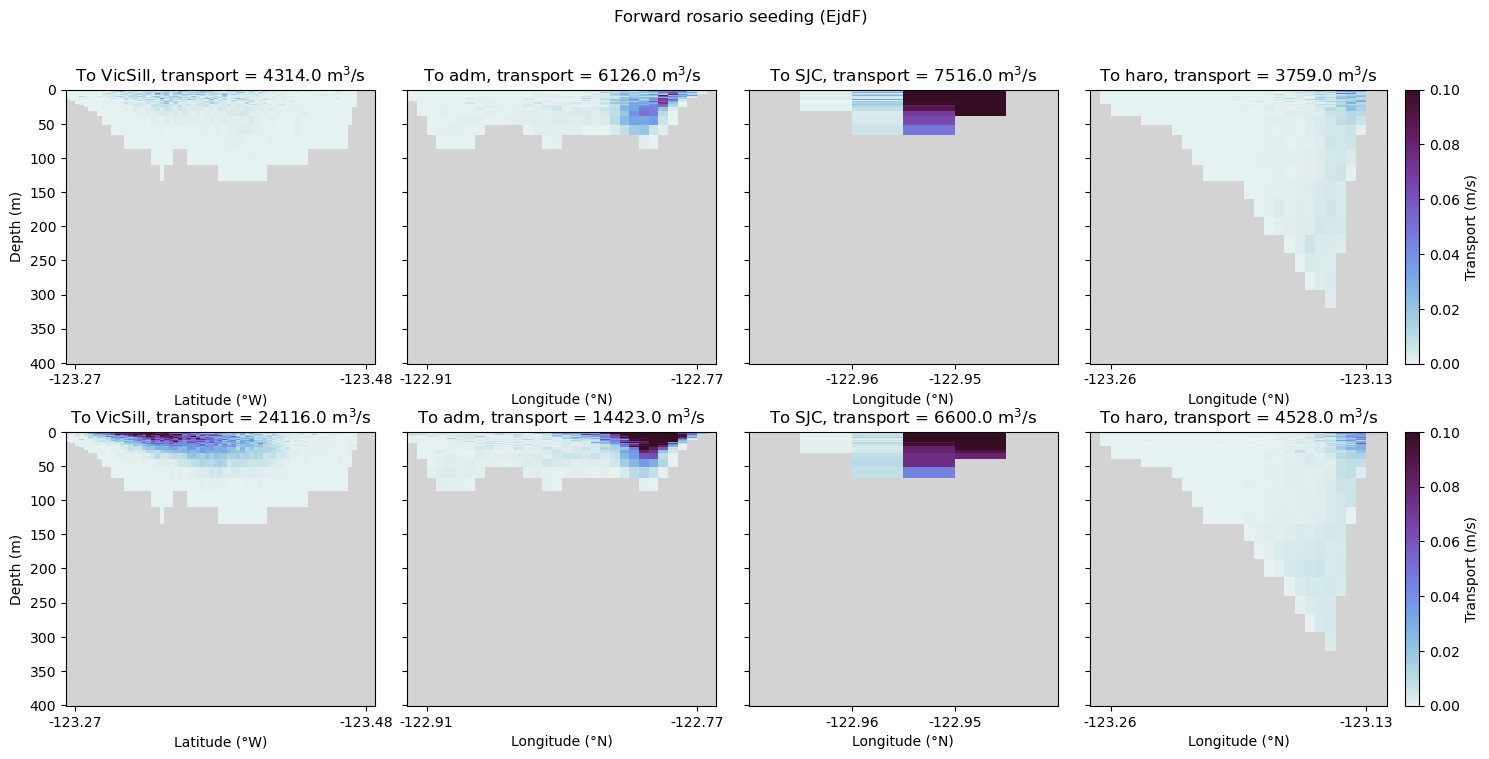

In [23]:
lonWvs = 235
lonEvs = 304
latvs = 178
vmax = 0.1

title = 'To VicSill, transport = ' + str(np.round(np.sum(dict_all['rostovs_RS']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title2 = 'To adm, transport = ' + str(np.round(np.sum(dict_all['rostoadm']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title3 = 'To haro, transport = ' + str(np.round(np.sum(dict_all['rostoharo']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'
title4 = 'To SJC, transport = ' + str(np.round(np.sum(dict_all['rostosjc']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'

title5 = 'To VicSill, transport = ' + str(np.round(np.sum(dict_all['rostovs_RS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title6 = 'To adm, transport = ' + str(np.round(np.sum(dict_all['rostoadm']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title7 = 'To haro, transport = ' + str(np.round(np.sum(dict_all['rostoharo']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'
title8 = 'To SJC, transport = ' + str(np.round(np.sum(dict_all['rostosjc']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]))) + f' m$^3$/s'

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(18,8),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,dict_all['rostovs_RS']['final_lon'][months[idx_dec]].dropna(),dict_all['rostovs_RS']['final_z'][months[idx_dec]].dropna(),dict_all['rostovs_RS']['final_transp'][months[idx_dec]].dropna(),lonWvs,lonEvs,latvs,38,vmax,23*days_month[idx_dec],title,False,True,NW=True)
plotCS(ax2,dict_all['rostoadm']['final_lon'][months[idx_dec]].dropna(),dict_all['rostoadm']['final_z'][months[idx_dec]].dropna(),dict_all['rostoadm']['final_transp'][months[idx_dec]].dropna(),lonWadm,lonEadm,latadm,38,vmax,23*days_month[idx_dec],title2,False,False)
plotCS(ax4,dict_all['rostoharo']['final_lon'][months[idx_dec]].dropna(),dict_all['rostoharo']['final_z'][months[idx_dec]].dropna(),dict_all['rostoharo']['final_transp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,vmax,23*days_month[idx_dec],title3,True,False)
plotCS(ax3,dict_all['rostosjc']['final_lon'][months[idx_dec]].dropna(),dict_all['rostosjc']['final_z'][months[idx_dec]].dropna(),dict_all['rostosjc']['final_transp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,vmax,23*days_month[idx_dec],title4,False,False)

plotCS(ax5,dict_all['rostovs_RS']['final_lon'][months[idx_jun]].dropna(),dict_all['rostovs_RS']['final_z'][months[idx_jun]].dropna(),dict_all['rostovs_RS']['final_transp'][months[idx_jun]].dropna(),lonWvs,lonEvs,latvs,38,vmax,23*days_month[idx_jun],title5,False,True,NW=True)
plotCS(ax6,dict_all['rostoadm']['final_lon'][months[idx_jun]].dropna(),dict_all['rostoadm']['final_z'][months[idx_jun]].dropna(),dict_all['rostoadm']['final_transp'][months[idx_jun]].dropna(),lonWadm,lonEadm,latadm,38,vmax,23*days_month[idx_jun],title6,False,False)
plotCS(ax8,dict_all['rostoharo']['final_lon'][months[idx_jun]].dropna(),dict_all['rostoharo']['final_z'][months[idx_jun]].dropna(),dict_all['rostoharo']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,vmax,23*days_month[idx_jun],title7,True,False)
plotCS(ax7,dict_all['rostosjc']['final_lon'][months[idx_jun]].dropna(),dict_all['rostosjc']['final_z'][months[idx_jun]].dropna(),dict_all['rostosjc']['final_transp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,vmax,23*days_month[idx_jun],title8,False,False)

fig.suptitle('Forward rosario seeding (EjdF)')
fig.subplots_adjust(wspace=0.1,hspace=0.25)

In [15]:
np.sum(dict_all['vstoharo']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec])

48772.77785104473

In [16]:
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

np.sum(dict_all['vstoharo']['final_transp']['jun'])/(23*30)
np.round(np.sum(dict_all['vstoharo']['final_transp']['jun'])/(23*30))

97596.0